In [64]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Union, Optional, Iterable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BenchmarkStrategy import BenchmarkStrategy
from MovingAverageStrategy import MovingAverageStrategy
from RSIStrategy import RSIStrategy
from MACDStrategy import MACDStrategy
from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy


from pathlib import Path

### Helper Functions

In [72]:
def plot_cum_pnl_all_strategies(df_histories, as_pct=False, title="Cumulative PnL — All Strategies"):
    """
    Plots cumulative PnL across all strategies on one chart.

    Parameters
    ----------
    df_histories : pd.DataFrame
        MultiIndex by ["Strategy","Timestamp"], columns include either:
          - 'CumulativePnL', OR
          - 'Cash' and 'Holdings' (will compute TotalValue and baseline PnL)
    as_pct : bool
        If True, shows cumulative performance relative to the first timestamp (in %).
        If False, shows PnL in dollars.
    title : str
        Plot title.
    """
    # Work on a copy
    df = df_histories.copy()

    # Ensure we have TotalValue if needed
    if "CumulativePnL" not in df.columns:
        if "TotalValue" not in df.columns:
            if not {"Cash","Holdings"}.issubset(df.columns):
                raise ValueError("Need either 'CumulativePnL' or both 'Cash' and 'Holdings' in df_histories.")
            df["TotalValue"] = df["Cash"] + df["Holdings"]

    plt.figure(figsize=(10, 6))

    for strat, g in df.groupby(level="Strategy"):
        g = g.sort_index()  # sort by Timestamp within each strategy

        if "CumulativePnL" in g.columns:
            series = g["CumulativePnL"]
            ylab = "Cumulative PnL ($)"
        else:
            # Baseline from first TotalValue per strategy
            first_val = g["TotalValue"].iloc[0]
            if as_pct:
                series = (g["TotalValue"] / first_val - 1.0) * 100.0
                ylab = "Cumulative Return (%)"
            else:
                series = g["TotalValue"] - first_val
                ylab = "Cumulative PnL ($)"

        # x-axis is the Timestamp level
        x = g.index.get_level_values("Timestamp")
        plt.plot(x, series, label=strat, linewidth=2)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylab)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [35]:
def load_strategy_histories(strategies) -> pd.DataFrame:
    base_dir = Path.cwd().parent

    perf_dir = base_dir / "Assignment_2_Results"
    perf_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

    dfs = []

    for s in strategies:
        name = s.__class__.__name__
        file_path = perf_dir / f"{name}_portfolio_history.csv"

        if not file_path.exists():
            print(f"[WARN] File not found for {name}: {file_path}")
            continue

        df = pd.read_csv(file_path, parse_dates=["Timestamp"])
        df["Strategy"] = name
        dfs.append(df)


    if not dfs:
        raise FileNotFoundError("No strategy performance files found in data/prices/")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all.sort_values(by=["Timestamp", "Strategy"], inplace=True)

    return df_all

In [76]:
def plot_total_value_all_strategies(df_histories):
    plt.figure(figsize=(10,6))
    colors = plt.cm.tab10.colors  # auto palette

    for i, (strategy, group) in enumerate(df_histories.groupby(level="Strategy")):
        g = group.sort_index()
        if "TotalValue" not in g.columns:
            g = g.assign(TotalValue=g["Cash"] + g["Holdings"])
        plt.plot(g.index.get_level_values("Timestamp"), g["TotalValue"],
                 label=strategy, color=colors[i % len(colors)], linewidth=2)

    plt.title("Total Portfolio Value Across Strategies")
    plt.xlabel("Date")
    plt.ylabel("Dollars ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [77]:
def strategy_cash_holdings_tv(df_histories, strategy):
    """
    Plots a compact chart of Cash, Holdings, and Total Value for one strategy.
    """
    # Extract that strategy’s data
    g = df_histories.xs(strategy, level="Strategy").sort_index()

    # Compute Total Value if missing
    if "TotalValue" not in g.columns:
        g = g.assign(TotalValue=g["Cash"] + g["Holdings"])

    # Create small figure
    plt.figure(figsize=(5, 3))
    plt.plot(g.index.get_level_values("Timestamp"), g["Cash"], color="black", label="Cash")
    plt.plot(g.index.get_level_values("Timestamp"), g["Holdings"], color="blue", label="Holdings")
    plt.plot(g.index.get_level_values("Timestamp"), g["TotalValue"], color="green", label="Total Value")

    plt.title(strategy, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Value ($)")
    plt.legend(fontsize=7, loc="best")
    plt.tight_layout()
    plt.show()

### Load Results from all strategies

In [55]:
strategies = [BenchmarkStrategy(),
                 MovingAverageStrategy(), 
                 RSIStrategy(),
                 MACDStrategy() , 
#                  VolatilityBreakoutStrategy()
                    ]

df_histories = load_strategy_histories(strategies).reset_index(drop=True)

cols = ["Strategy"] + [c for c in df_histories.columns if c != "Strategy"]
df_histories = df_histories[cols]

df_histories = df_histories.set_index(["Strategy", "Timestamp"]).sort_index()

df_histories["Total Value"] = df_histories["Cash"] + df_histories["Holdings"]

df_histories.head(10)

Cash       Holdings     Total Value
Strategy          Timestamp                                               
BenchmarkStrategy 2005-01-03  999829.184551     170.815449  1000000.000000
                  2005-01-04  853410.067829  146585.425736   999995.493565
                  2005-01-05  853410.067829  144776.978619   998187.046448
                  2005-01-06  853410.067829  143975.727368   997385.795197
                  2005-01-07  853410.067829  144540.648021   997950.715850
                  2005-01-10  853410.067829  144128.030156   997538.097985
                  2005-01-11  853410.067829  144853.744848   998263.812677
                  2005-01-12  853410.067829  144050.391644   997460.459473
                  2005-01-13  853410.067829  144272.056398   997682.124227
                  2005-01-14  853410.067829  143835.099467   997245.167296

## Plot 1: Signal Overlay on Price Chart

## Plot 2: Holdings, Cash and Total Assets Over Time

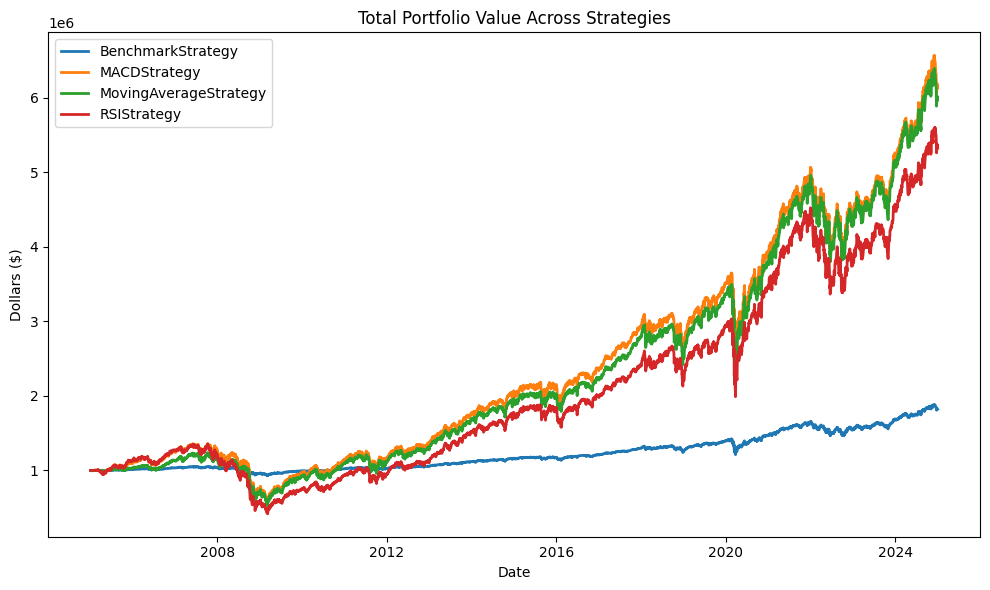

In [71]:
plot_total_value_all_strategies(df_histories)

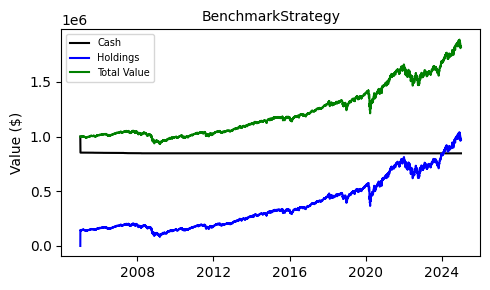

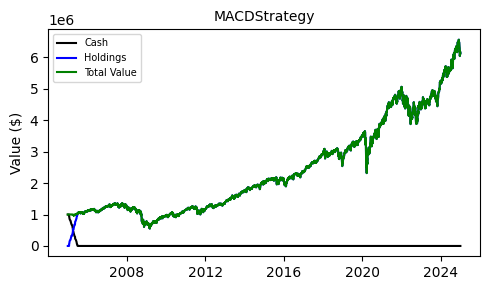

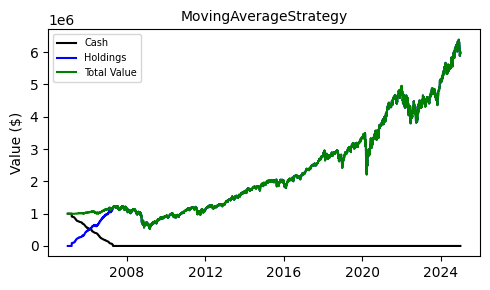

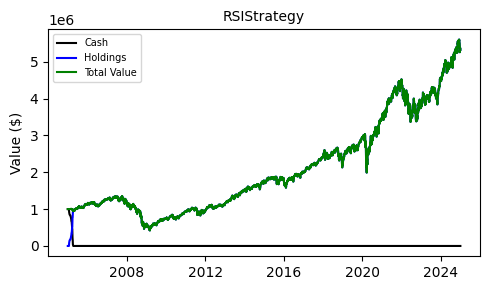

In [68]:
for strat in df_histories.index.get_level_values("Strategy").unique():
    strategy_cash_holdings_tv(df_histories, strat)

## Plot 3: Compare Cumulative PnL Across Strategies

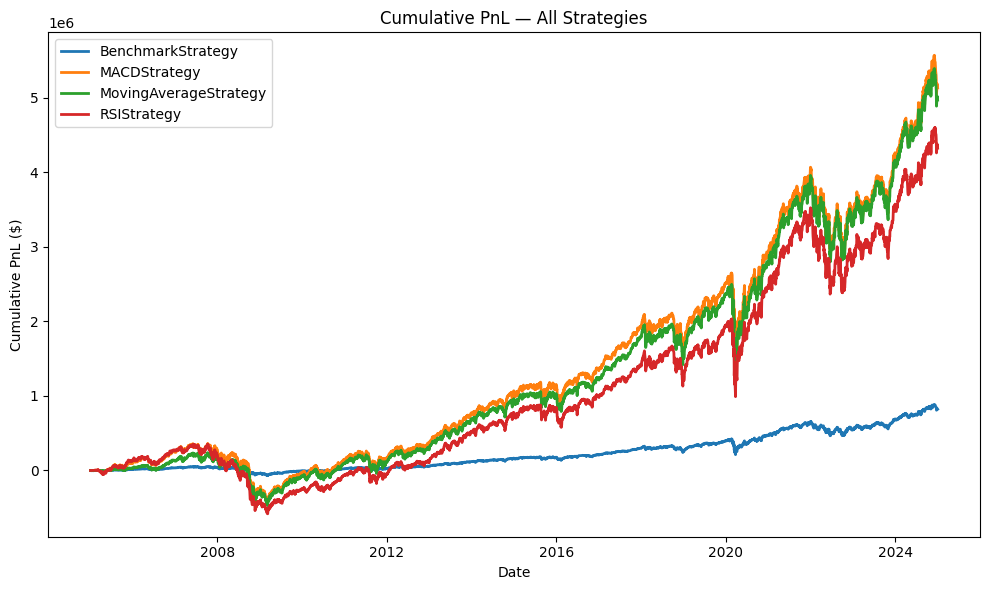

In [75]:
plot_cum_pnl_all_strategies(df_histories, as_pct=False)

## Reflection on Signal Behavior, Execution Constraints, and Performance